In [2]:
import pickle, time
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import re
from pathlib import Path
import pandas as pd
from typing import List, Dict
from tqdm.notebook import tqdm   
import numpy as np        

from dgd.environments.drl3env_loader4 import _apply_implicit_or, _compute_hash, _compute_truth_key

from dgd.utils.utils5 import (
    calculate_truth_table_v2,
    generate_one_hot_features_from_adj,
    resize_matrix,
    energy_score,
    check_implicit_OR_existence_v3,
    add_implicit_OR_to_dag_v2,
    exhaustive_cut_enumeration_dag,
    is_fanout_free_standalone,
    generate_subgraph,
    simulate_signal_propagation_binary,
    plot_circuit_layered,
    write_tt_files,
)

from dgd.utils.verification import *

Done loading action motifs. There are 15928 unique motifs.


In [4]:
MOTIFS_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/action_motifs.pkl"
with open(MOTIFS_PATH, "rb") as f:
    action_motifs = pickle.load(f)

UNIQUE_GRAPHS = action_motifs["graphs"]       
TTABLE_TO_ACTIONS = action_motifs["lookup"]

def build_motif_canonicals():
    """
    Compute canonical form for every motif in global UNIQUE_GRAPHS and
    store them in UNIQUE_GRAPHS_canonical, with a progress bar.
    """
    global UNIQUE_GRAPHS_canonical
    bar = tqdm(UNIQUE_GRAPHS, desc="Canonicalising motifs", unit="motif")
    UNIQUE_GRAPHS_canonical = [_apply_implicit_or(g.copy()) for g in bar]
    print(f"Built canonical bank for {len(UNIQUE_GRAPHS_canonical)} motifs.")
    
#plot_circuit_layered(G, show_in_notebook=True)

In [5]:
import networkx as nx
from tqdm import tqdm

def graphs_changed_by_implicit_or(
    graphs,
    node_attr_keys=None,
    edge_attr_keys=None,
    show_progress=True,
):
    """
    Compare each graph to its _apply_implicit_or-transformed version and report
    how many are non-isomorphic to their original.

    Parameters
    ----------
    graphs : list[networkx.Graph or DiGraph]
        The motifs to check (e.g., UNIQUE_GRAPHS).
    node_attr_keys : list[str] | None
        If provided, node attributes to include in the isomorphism test.
    edge_attr_keys : list[str] | None
        If provided, edge attributes to include in the isomorphism test.
    show_progress : bool
        Whether to show a tqdm progress bar.

    Returns
    -------
    count_changed : int
        Number of graphs that changed up to isomorphism.
    changed_indices : list[int]
        Indices of graphs that changed.
    """
    # Build attribute matchers if requested
    node_match = None
    edge_match = None

    if node_attr_keys:
        def node_match(a, b):
            return all(a.get(k) == b.get(k) for k in node_attr_keys)
    if edge_attr_keys:
        def edge_match(a, b):
            return all(a.get(k) == b.get(k) for k in edge_attr_keys)

    iterator = enumerate(graphs)
    if show_progress:
        iterator = tqdm(iterator, total=len(graphs), desc="Checking isomorphism", unit="graph")

    count_changed = 0
    changed_indices = []

    for i, g in iterator:
        g2 = _apply_implicit_or(g.copy())
        iso = nx.is_isomorphic(g, g2, node_match=node_match, edge_match=edge_match)
        if not iso:
            count_changed += 1
            changed_indices.append(i)

    print(f"{count_changed} / {len(graphs)} graphs changed up to isomorphism after _apply_implicit_or.")
    return count_changed, changed_indices

# --- Usage ---
count_changed, changed_idxs = graphs_changed_by_implicit_or(UNIQUE_GRAPHS)
# If you want attribute-aware matching, e.g. include 'type' on nodes and 'label' on edges:
# count_changed, changed_idxs = graphs_changed_by_implicit_or(UNIQUE_GRAPHS, node_attr_keys=["type"], edge_attr_keys=["label"])


Checking isomorphism:   0%|          | 0/15928 [00:00<?, ?graph/s]

Checking isomorphism: 100%|██████████| 15928/15928 [00:34<00:00, 458.80graph/s]

7630 / 15928 graphs changed up to isomorphism after _apply_implicit_or.


Showing 5 randomly selected changed motifs: [12180, 4768, 3204, 13406, 7545]

Changed motif index: 12180 (before → after)


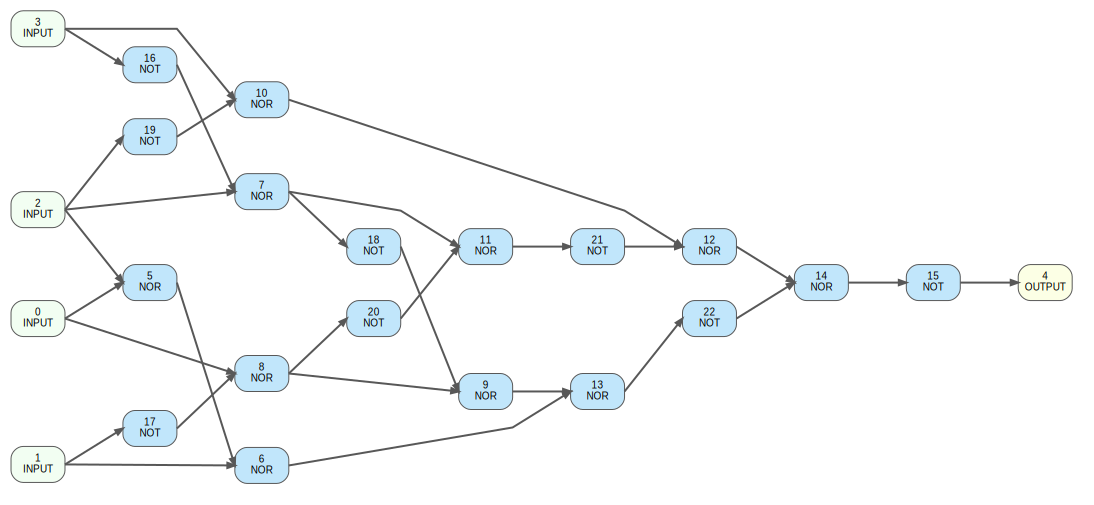

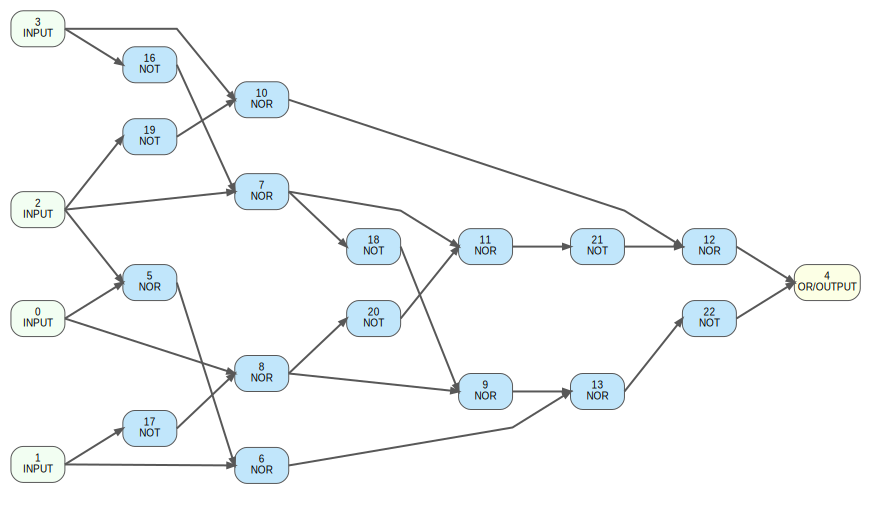


Changed motif index: 4768 (before → after)


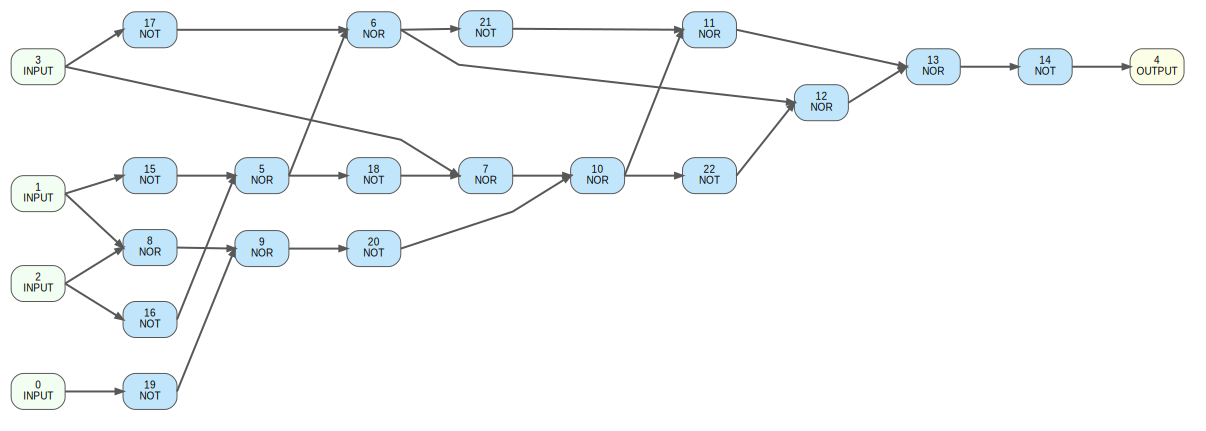

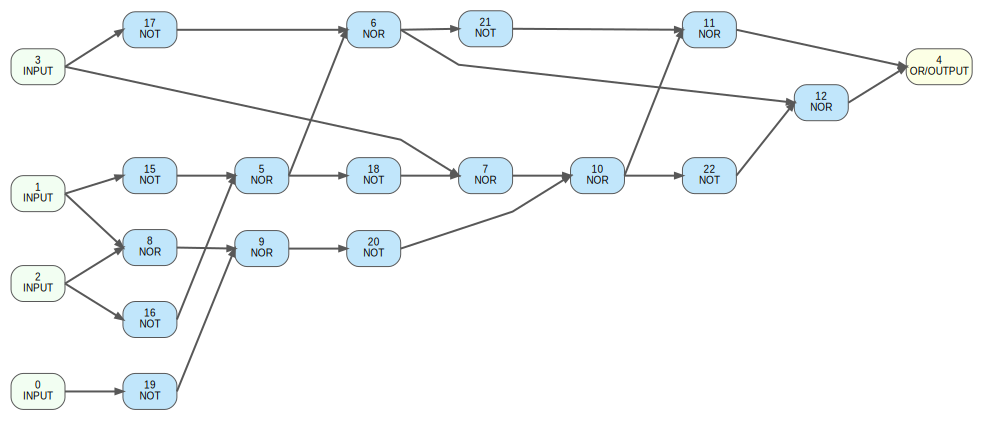


Changed motif index: 3204 (before → after)


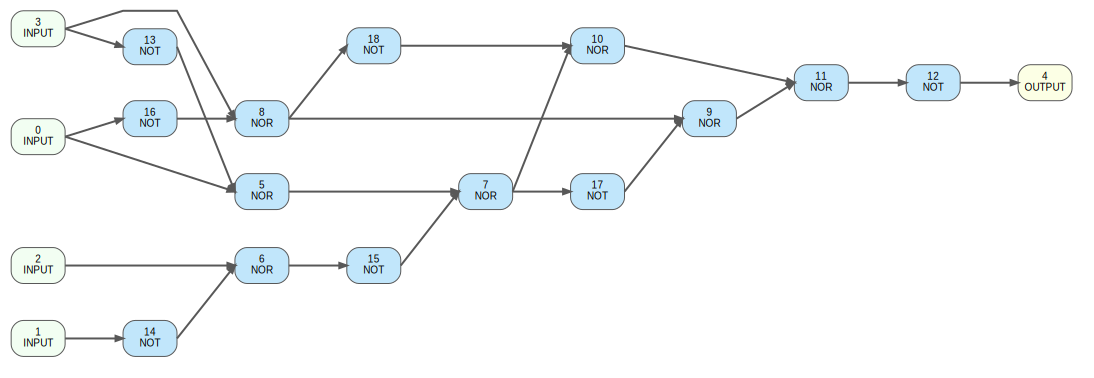

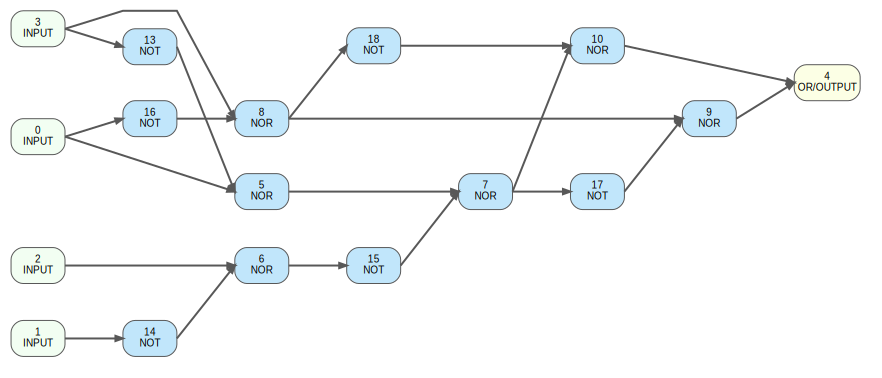


Changed motif index: 13406 (before → after)


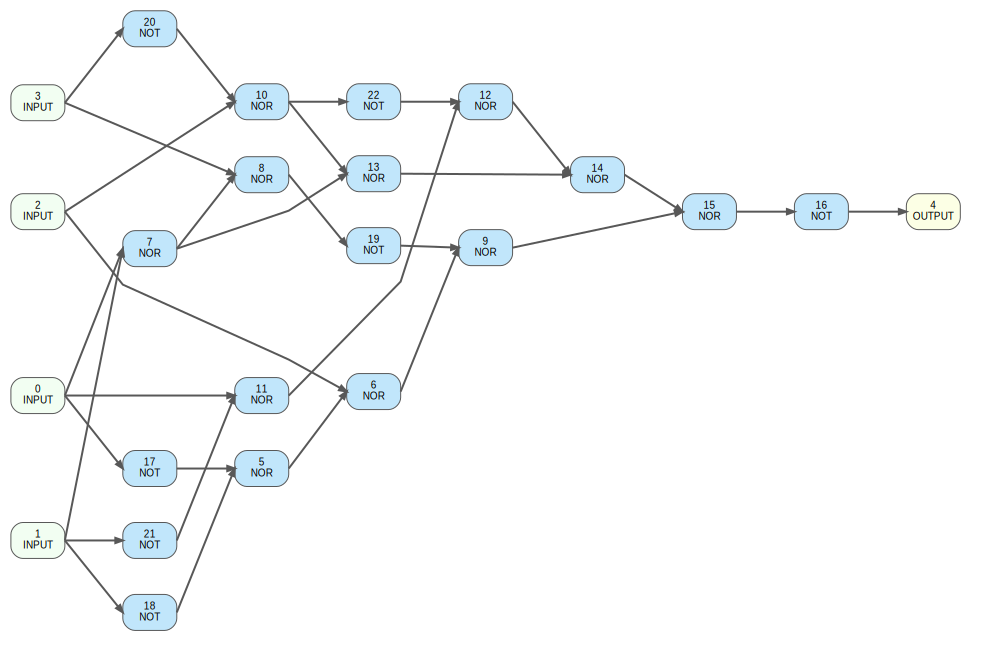

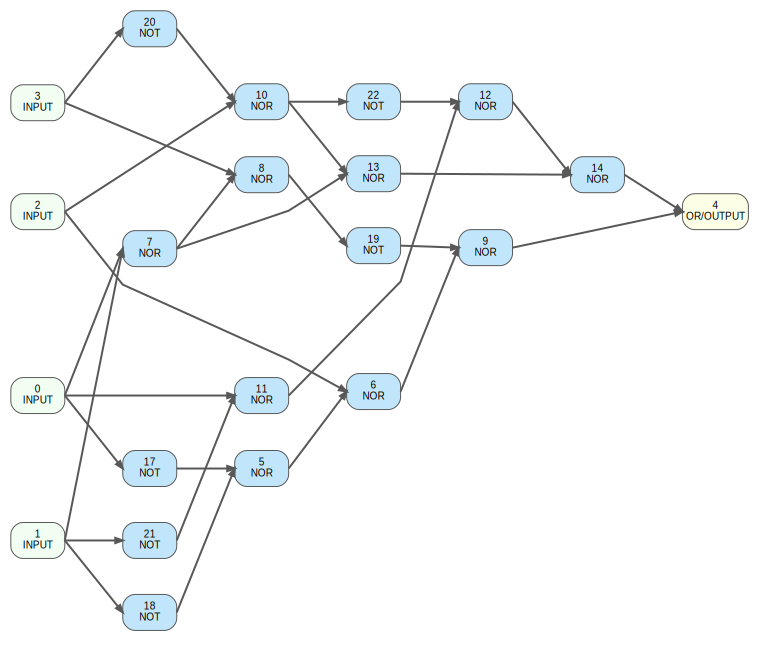


Changed motif index: 7545 (before → after)


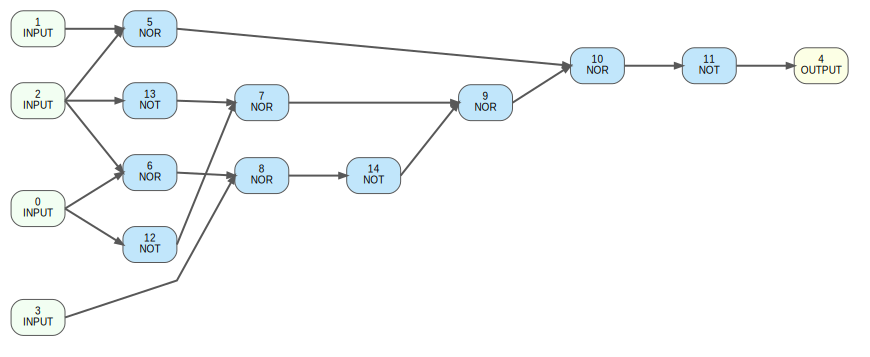

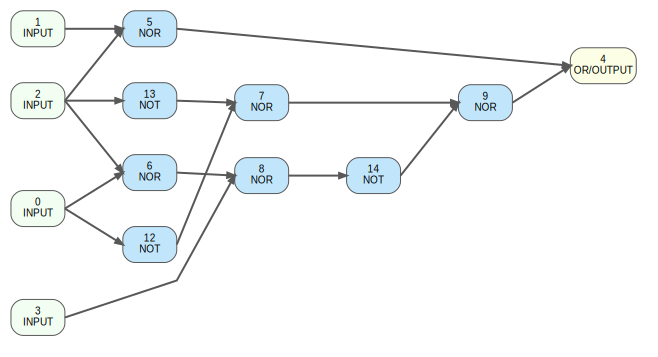

In [9]:
import random

N = 5         # how many changed motifs to visualize
seed = 42     # set None for non-deterministic sampling

if changed_idxs:
    rng = random.Random(seed)
    picks = rng.sample(changed_idxs, k=min(N, len(changed_idxs)))
    print(f"Showing {len(picks)} randomly selected changed motifs:", picks)

    for i in picks:
        G0 = UNIQUE_GRAPHS[i]
        G1 = _apply_implicit_or(G0.copy())
        print(f"\nChanged motif index: {i} (before → after)")
        plot_circuit_layered(G0, show_in_notebook=True)
        plot_circuit_layered(G1, show_in_notebook=True)
else:
    print("No changed motifs to visualize.")


Loaded 6 graphs from:
/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/scratch_training/0x2B/seed_1/optimal_topologies/optimal_topologies.pkl
UNIQUE_GRAPHS_canonical not found; building it with _apply_implicit_or...


Canonicalising motifs: 100%|██████████| 15928/15928 [00:22<00:00, 702.64motif/s]


Built canonical bank for 15928 motifs.


Testing graphs:   0%|          | 0/6 [00:00<?, ?graph/s]


=== Test graph #0 ===


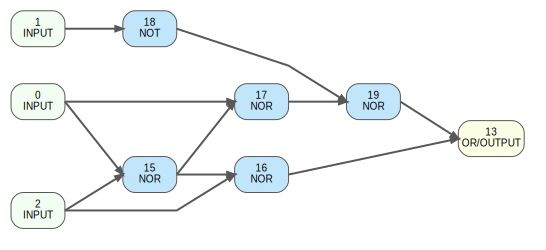

Testing graphs:  17%|█▋        | 1/6 [00:00<00:00,  5.94graph/s]

No isomorphic match found in UNIQUE_GRAPHS.
No isomorphic match found in UNIQUE_GRAPHS_canonical.

=== Test graph #1 ===


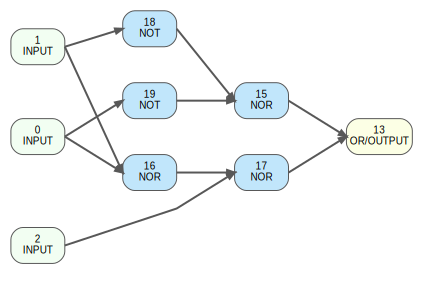

Testing graphs:  33%|███▎      | 2/6 [00:00<00:00,  5.97graph/s]

No isomorphic match found in UNIQUE_GRAPHS.
No isomorphic match found in UNIQUE_GRAPHS_canonical.

=== Test graph #2 ===


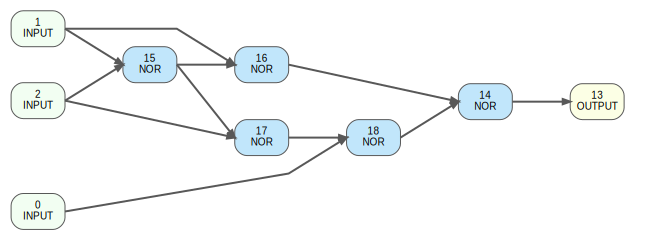

Testing graphs:  50%|█████     | 3/6 [00:00<00:00,  6.13graph/s]

Isomorphic to UNIQUE_GRAPHS indices (showing up to 5): [238]
Isomorphic to UNIQUE_GRAPHS_canonical indices (up to 5): [238]

=== Test graph #3 ===


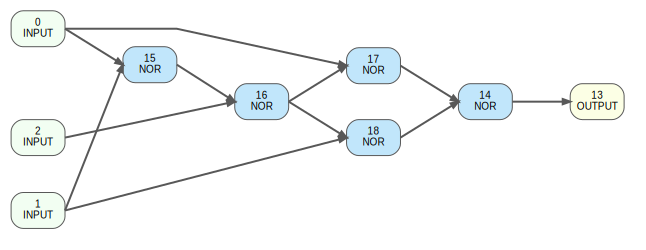

Testing graphs:  67%|██████▋   | 4/6 [00:00<00:00,  6.23graph/s]

Isomorphic to UNIQUE_GRAPHS indices (showing up to 5): [223]
Isomorphic to UNIQUE_GRAPHS_canonical indices (up to 5): [223]

=== Test graph #4 ===


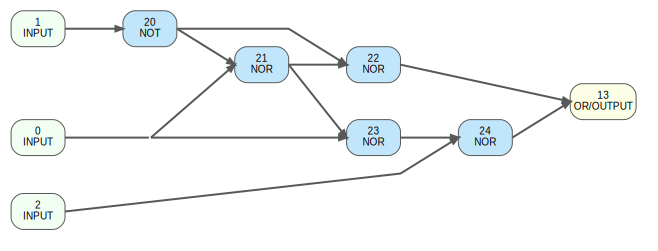

Testing graphs:  83%|████████▎ | 5/6 [00:00<00:00,  6.16graph/s]

No isomorphic match found in UNIQUE_GRAPHS.
No isomorphic match found in UNIQUE_GRAPHS_canonical.

=== Test graph #5 ===


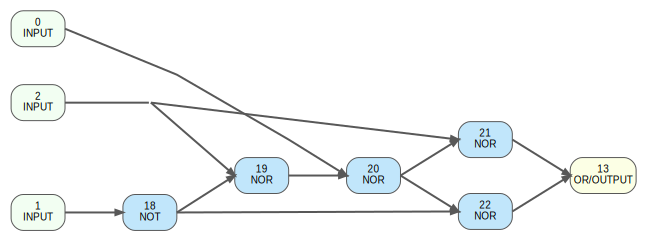

Testing graphs: 100%|██████████| 6/6 [00:01<00:00,  5.70graph/s]

No isomorphic match found in UNIQUE_GRAPHS.
No isomorphic match found in UNIQUE_GRAPHS_canonical.


Testing graphs: 100%|██████████| 6/6 [00:01<00:00,  5.89graph/s]


In [10]:
import pickle
import os
from tqdm import tqdm
import networkx as nx

PKL_PATH = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/manuscript/exp/scratch_training/0x2B/seed_1/optimal_topologies/optimal_topologies.pkl"

# --- Load graphs to test ---
with open(PKL_PATH, "rb") as f:
    data = pickle.load(f)

# Handle either a list of graphs or a dict containing them.
if isinstance(data, dict):
    # Best guess at common keys; adjust if needed.
    for key in ["graphs", "topologies", "optimal_graphs", "Gs"]:
        if key in data:
            TEST_GRAPHS = data[key]
            break
    else:
        # Fall back: if dict values look like graphs, take all values
        TEST_GRAPHS = [v for v in data.values() if hasattr(v, "nodes") and hasattr(v, "edges")]
else:
    TEST_GRAPHS = data

assert isinstance(TEST_GRAPHS, (list, tuple)), "Loaded object does not contain a list/tuple of graphs."
print(f"Loaded {len(TEST_GRAPHS)} graphs from:\n{PKL_PATH}")

# --- Ensure UNIQUE_GRAPHS_canonical is available ---
try:
    _ = UNIQUE_GRAPHS_canonical  # noqa
except NameError:
    print("UNIQUE_GRAPHS_canonical not found; building it with _apply_implicit_or...")
    UNIQUE_GRAPHS_canonical = [_apply_implicit_or(g.copy()) for g in tqdm(UNIQUE_GRAPHS, desc="Canonicalising motifs", unit="motif")]
    print(f"Built canonical bank for {len(UNIQUE_GRAPHS_canonical)} motifs.")

# --- Utilities for fast candidate pruning before isomorphism checks ---
def graph_signature(G):
    """Simple structure-only signature for candidate pruning."""
    n = G.number_of_nodes()
    m = G.number_of_edges()
    if isinstance(G, (nx.DiGraph, nx.MultiDiGraph)):
        degs = sorted((G.in_degree(v), G.out_degree(v)) for v in G.nodes())
    else:
        degs = sorted(G.degree(v) for v in G.nodes())
    return (n, m, tuple(degs))

def build_sig_index(graphs):
    """Map signature -> list of indices in graphs."""
    sig_index = {}
    for i, g in enumerate(graphs):
        sig = graph_signature(g)
        sig_index.setdefault(sig, []).append(i)
    return sig_index

SIG_UNIQUE = build_sig_index(UNIQUE_GRAPHS)
SIG_CANON  = build_sig_index(UNIQUE_GRAPHS_canonical)

def iso_matches_against_bank(G, bank, sig_index, max_report=5):
    """Return up to max_report indices of isomorphic matches in bank."""
    sig = graph_signature(G)
    candidates = sig_index.get(sig, [])
    hits = []
    for j in candidates:
        if nx.is_isomorphic(G, bank[j]):
            hits.append(j)
            if len(hits) >= max_report:
                break
    return hits

# --- Loop over test graphs: plot + check isomorphism ---
for idx, G in enumerate(tqdm(TEST_GRAPHS, desc="Testing graphs", unit="graph")):
    print(f"\n=== Test graph #{idx} ===")
    plot_circuit_layered(G, show_in_notebook=True)

    hits_unique = iso_matches_against_bank(G, UNIQUE_GRAPHS, SIG_UNIQUE, max_report=5)
    if hits_unique:
        print(f"Isomorphic to UNIQUE_GRAPHS indices (showing up to 5): {hits_unique}")
    else:
        print("No isomorphic match found in UNIQUE_GRAPHS.")

    hits_canon = iso_matches_against_bank(G, UNIQUE_GRAPHS_canonical, SIG_CANON, max_report=5)
    if hits_canon:
        print(f"Isomorphic to UNIQUE_GRAPHS_canonical indices (up to 5): {hits_canon}")
    else:
        print("No isomorphic match found in UNIQUE_GRAPHS_canonical.")
